In [14]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [15]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1 #binary for whether it is digit or not
        
bin_digit = 8
epochs = 10            
batch_size = 64        
learning_rate = 0.001

In [16]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [18]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [19]:
#create net
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

#Loss: is it a specific number or not (e.g., 3)?
criterion = nn.BCEWithLogitsLoss() #uses sigmoid

#Optimiser for gradient descent:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

![Alt Text](<https://miro.medium.com/v2/resize:fit:1003/1*1kCwAuqqte7r3LeiiP1FDQ.jpeg>)


In [20]:
print(CUDA)

True


In [21]:
#train:

for epoch in range(epochs):
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        #(batch,1,28,28)
        images = images.view(-1, 28*28)
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()

        labels = (labels == bin_digit).float().view(-1, 1)  #if bin_digit: label = 1, else 0

        outputs = net(images)  #[batch_size, 1]

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = (torch.sigmoid(outputs) >= 0.5).float() #activated output (logits) to binary

        correct_train += (predicted == labels).sum().item()

    accuracy = 100 * correct_train / len(train_dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.3f}, Training Accuracy: {accuracy:.3f}%')

print("DONE TRAINING!")

torch.save(net.state_dict(), 'binary_ffn.pth')


Epoch [1/10], Training Loss: 0.113, Training Accuracy: 96.392%
Epoch [2/10], Training Loss: 0.042, Training Accuracy: 98.593%
Epoch [3/10], Training Loss: 0.030, Training Accuracy: 98.980%
Epoch [4/10], Training Loss: 0.025, Training Accuracy: 99.152%
Epoch [5/10], Training Loss: 0.020, Training Accuracy: 99.345%
Epoch [6/10], Training Loss: 0.017, Training Accuracy: 99.432%
Epoch [7/10], Training Loss: 0.015, Training Accuracy: 99.527%
Epoch [8/10], Training Loss: 0.012, Training Accuracy: 99.577%
Epoch [9/10], Training Loss: 0.010, Training Accuracy: 99.673%
Epoch [10/10], Training Loss: 0.009, Training Accuracy: 99.695%
DONE TRAINING!


In [22]:
net.load_state_dict(torch.load('binary_ffn.pth'))

<All keys matched successfully>

In [23]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        labels = (labels == bin_digit).float().view(-1, 1)
        outputs = net(images)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 99.31 %


In [30]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter
import random as ra

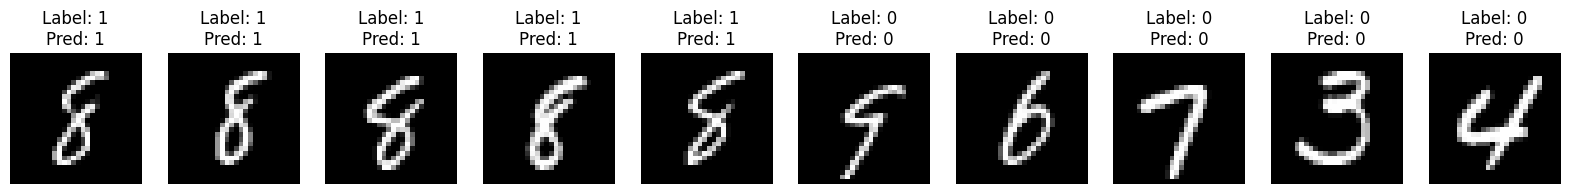

In [35]:
#examples:

net.eval()


data_iter = iter(test_loader)
batch_list = list(data_iter)
random_batch = ra.choice(batch_list)
images, labels = random_batch

pos_idx = (labels == bin_digit).nonzero(as_tuple=True)[0]
neg_idx = (labels != bin_digit).nonzero(as_tuple=True)[0]

n = 10  #how many imgs to display
half_n = n // 2
selected_idx = torch.cat([pos_idx[:half_n], neg_idx[:half_n]])

selected_images = images[selected_idx].cuda()
selected_labels = labels[selected_idx]

inputs = selected_images.view(selected_images.size(0), -1)
outputs = net(inputs)
preds = (torch.sigmoid(outputs) >= 0.5).float().squeeze().cpu() #activate logits out to binary 

plt.figure(figsize=(n * 2, 4))
for i in range(selected_images.size(0)):
    plt.subplot(1, n, i+1)
    plt.imshow(selected_images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'Label: {int(selected_labels[i].item() == bin_digit)}\nPred: {int(preds[i])}')
    plt.axis('off')
plt.show()


In [ ]:
#activation maximization, LRP